# Fit against KYDEX DW ONLY

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 24 Aug 23

@author: marcofking
"""


import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
import seaborn as sns
from scipy.integrate import odeint
import math
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test3.db"))



import warnings

In [11]:
#Could use PlotNine which is like ggplot2 
#Import LabData/cleaningExptBeth.csv
import pandas as pd
import seaborn as sns
df = pd.read_csv('../../Annabel_data/FINAL_cleaning_data.csv')
df.head()
#using seaborn make a line plot of Count vs TimeAfterCleaning and colour by CleaningType, on log scale 

df = df[(df['Surface'] == "KYDEX") & (df['Cleaning'] == "DW") & (df['Time'] > -.5)]

# Group by time and calculate the mean
grouped_data = df.groupby('Time').agg({'Count': ['mean', 'std']}).reset_index()
grouped_data.columns = ['Time', 'mean', 'std']
grouped_data


,Time,mean,std
0,0.0,960.500000,156.469486
1,1.0,683.500000,109.260697
2,2.0,750.166667,54.027462
3,4.0,888.833333,67.603008


<ErrorbarContainer object of 3 artists>

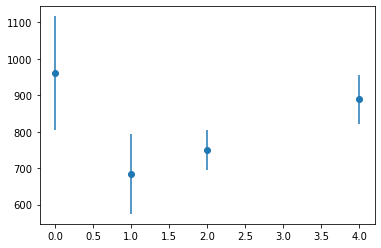

In [68]:
plt.errorbar(grouped_data['Time'].values,grouped_data['mean'].values,yerr=grouped_data['std'].values,fmt='o')


## Function to Fit

In [172]:
def logistic_decay_model(params):
    np.seterr(invalid='ignore')
    warnings.filterwarnings('ignore')
    #surface_key = surface.replace(' ', '_')  # Replace space with underscore
    r = params['r']#params[surface_key + '_r_' + cleaning]
    K = params['K']#params[surface_key + '_K_' + cleaning]
    m = params['m']#params[surface_key + '_m_' + cleaning]
    g = params['g']#params[surface_key + '_g_' + cleaning]
    C0 = params['C0']#params[surface_key + '_C0' ]  # Use the initial condition from the parameters
    times = np.array([0,1,2,4])
    def dCdt(C, t):
        cleaning_effect = m * np.exp(-g * t) * C if t >= 0 else 0
        return r * C * (1 - C / K) - cleaning_effect

    # Suppress the specified warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', message='t + h = t')
    warnings.filterwarnings('ignore', message='lsoda--  warning..internal t')
    C = odeint(dCdt, C0, times)
    return C.flatten()

In [177]:
np.sum(abs(grouped_data['mean']-logistic_decay_model({'r':0.3,'K':0.3,'m':0.3,'g':0.3,'C0':1000})))

2360.0840718760032

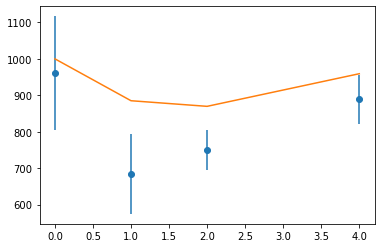

In [86]:
#Test

plt.errorbar(grouped_data['Time'].values,grouped_data['mean'].values,yerr=grouped_data['std'].values,fmt='o')
plt.plot(grouped_data['Time'].values,logistic_decay_model({'r':0.3,'K':1500,'m':0.3,'g':0.5,'C0':1000}))
plt.show()

In [162]:
def sample_params():
    r = 0 + 25 * np.random.rand(1)
    K = 0 + 3E4 * np.random.rand(1)
    m = 0 + 20 * np.random.rand(1)
    g = 0 + 25 * np.random.rand(1)
    C0 = 500 + 2.5E3 * np.random.randn(1)
    return r, K, m, g, C0

In [175]:
import os
import sys
from tqdm import tqdm
import numpy as np

epsilon = 250
num_samples = 1000
accepted_params = []

# Create a progress bar using tqdm
with tqdm(total=num_samples, desc="Sampling", ncols=100) as pbar:
    while len(accepted_params) < num_samples:

        
        # Your actual code here
        r, K, m, g, C0 = sample_params()
        params = {'r': r, 'K': K, 'm': m, 'g': g, 'C0': C0}  
        sim = logistic_decay_model(params)    
        dist = np.sum(abs(sim - grouped_data['mean']))

        
        if dist < epsilon:
            accepted_params.append(params)
            pbar.update(1)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1008382893412D+01   r2 =  0.9498145728840D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1008382893412D+01   r2 =  0.9498145728840D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1008382893412D+01   r2 =  0.7864299294003D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1009405448408D+01   r2 =  0.1015046055167D-15
 lsoda--  warning..internal t (=r1) 

KeyboardInterrupt: 

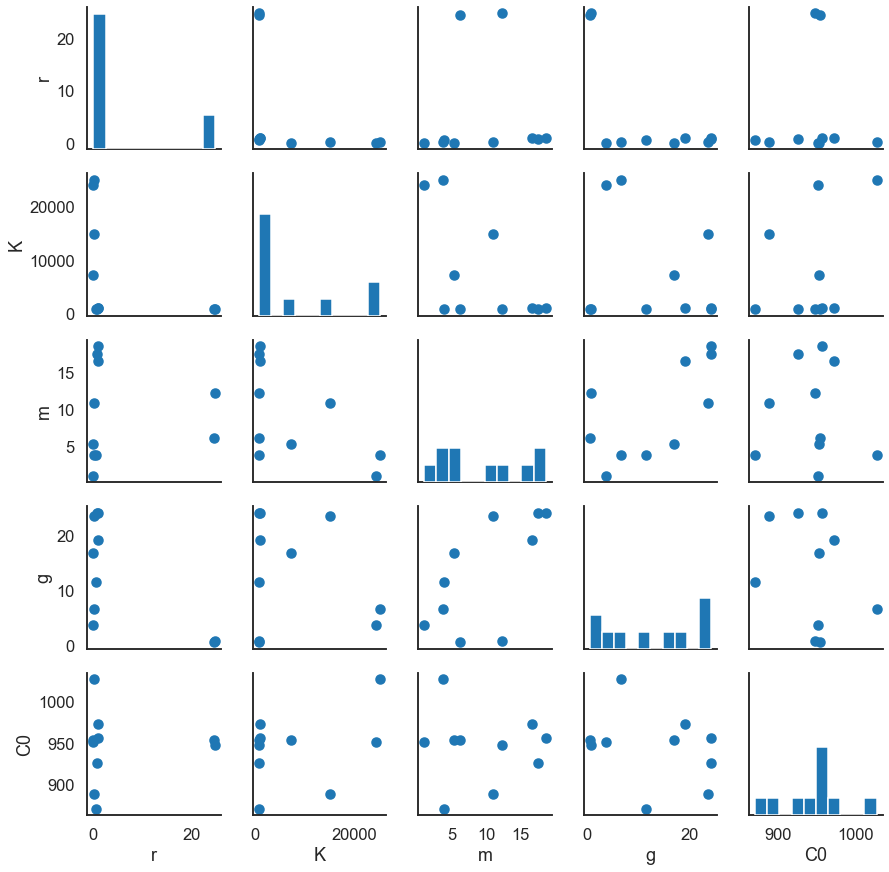

In [149]:
accepted_params = pd.DataFrame(accepted_params)
# Flatten the values
for col in accepted_params.columns:
    accepted_params[col] = accepted_params[col].apply(lambda x: x[0])

# Create the pair plot
sns.set_style('white')
sns.set_context('talk')
g = sns.PairGrid(accepted_params)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.show()




## Parameter Priors

In [13]:
parameter_prior = Distribution(K=RV("uniform", 6.0, 10_000.0),
                               r=RV("uniform", 0.01, 25.0),
                               m=RV("uniform", 0.1, 20.0),
                               g=RV("uniform", 0.01, 25.0),
                               C0 = RV("uniform",100,10_000))

parameter_prior.get_parameter_names()


['C0', 'K', 'g', 'm', 'r']

## Distance: Manhattan


In [26]:
def distance_manhattan(data, simulation):
    return np.absolute((data["mean"] - simulation["C"])).sum()

## Set up ABC

In [ ]:
from pyabc.populationstrategy import AdaptivePopulationSize


abc = ABCSMC(
    models=logistic_decay_model,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=AdaptivePopulationSize(1000, 0.15),
    # population_size=1000,
    transitions=LocalTransition(k_fraction=0.3),
    # eps=MedianEpsilon(500, median_multiplier=0.7),
)

history = abc.new(db_path, {"mean": grouped_data['mean']})

# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10)


## Matrix Plot

In [ ]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

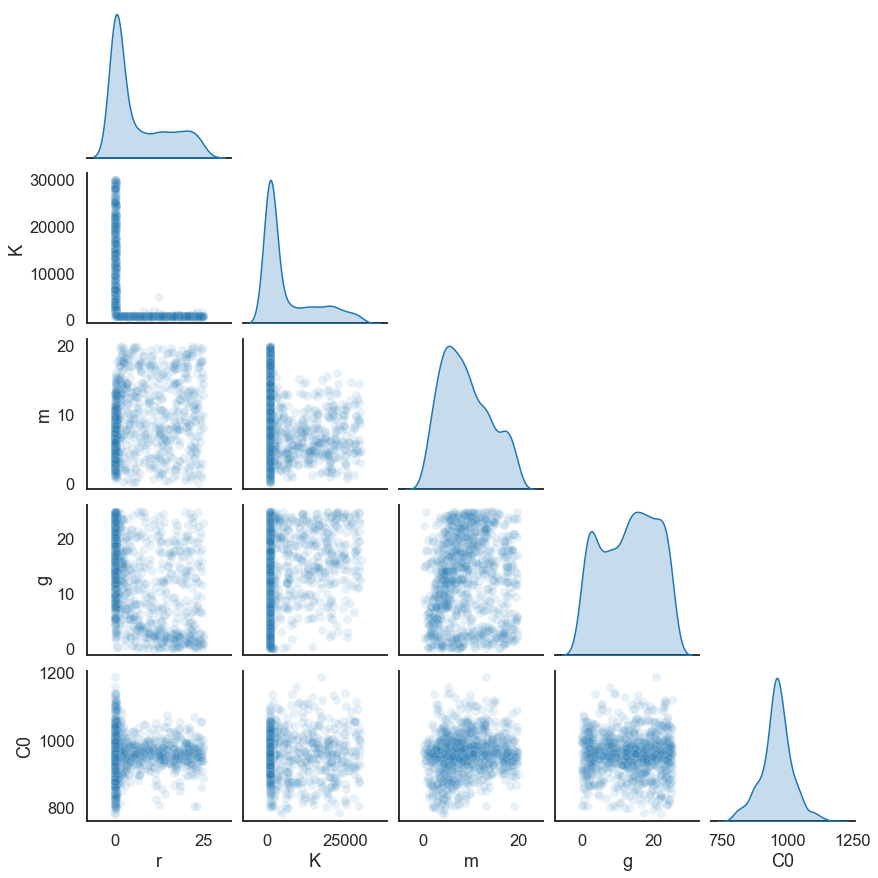

In [190]:
# read in accepted_params


# Explicitly specify the columns in pairplot
def plot_and_save_pairplot():
    # Load the accepted parameters from CSV
    df_accepted = pd.read_csv('accepted_parameters.csv')
    
    # Reset the index
    df_accepted.reset_index(inplace=True)
    
    # Convert list-type values to scalar values
    for col in df_accepted.columns:
        df_accepted[col] = df_accepted[col].apply(lambda x: eval(x)[0] if isinstance(x, str) and '[' in x else x)
    
    # Drop the distance column for the pairplot
    df_plot = df_accepted.drop(columns=['distance','index'])
    
    # Plot the pairplot and save
    sns.pairplot(df_plot, corner=True, diag_kind='kde', plot_kws={'alpha':0.1})
    #plt.savefig('pairplot.png')

plot_and_save_pairplot()

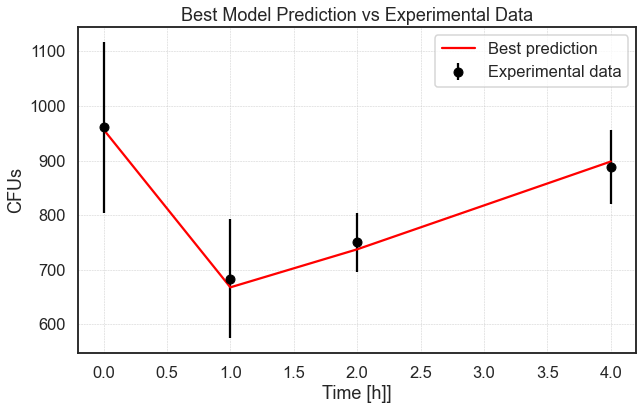

In [196]:
def load_and_process_data():
    """Load the data, filter it, and group by time."""
    df = pd.read_csv('../../Annabel_data/FINAL_cleaning_data.csv')
    df = df[(df['Surface'] == "KYDEX") & (df['Cleaning'] == "DW") & (df['Time'] > -.5)]
    grouped_data = df.groupby('Time').agg({'Count': ['mean', 'std']}).reset_index()
    grouped_data.columns = ['Time', 'mean', 'std']
    return grouped_data

def logistic_decay_model(params, times, grouped_data):
    """... [Your existing docstring or a new one describing the function] ..."""

    np.seterr(invalid='ignore')
    warnings.filterwarnings('ignore')
    #surface_key = surface.replace(' ', '_')  # Replace space with underscore
    r = params['r']#params[surface_key + '_r_' + cleaning]
    K = params['K']#params[surface_key + '_K_' + cleaning]
    m = params['m']#params[surface_key + '_m_' + cleaning]
    g = params['g']#params[surface_key + '_g_' + cleaning]
    C0 = params['C0']#params[surface_key + '_C0' ]  # Use the initial condition from the parameters
    times = np.array([0,1,2,4])
    def dCdt(C, t):
        cleaning_effect = m * np.exp(-g * t) * C if t >= 0 else 0
        return r * C * (1 - C / K) - cleaning_effect

    # Suppress the specified warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', message='t + h = t')
    warnings.filterwarnings('ignore', message='lsoda--  warning..internal t')
    C = odeint(dCdt, C0, times)
    return C.flatten()

def plot_best_prediction():
    # Load the accepted parameters from CSV
    df_accepted = pd.read_csv('accepted_parameters.csv')
    
    # Reset the index and convert list-type values to scalar values
    df_accepted.reset_index(inplace=True)
    for col in df_accepted.columns:
        df_accepted[col] = df_accepted[col].apply(lambda x: eval(x)[0] if isinstance(x, str) and '[' in x else x)
    
    # Sort by distance and get the best parameters
    df_accepted.sort_values(by='distance', inplace=True)
    best_params = df_accepted.iloc[0].drop('distance').to_dict()
    
    # Use the best parameters to generate predictions
    times = np.array([0,1,2,4])
    predictions = logistic_decay_model(best_params, times, grouped_data)
    
    # Plotting the results
    plt.figure(figsize=(10,6))
    
    # Plot experimental data with error bars
    plt.errorbar(grouped_data['Time'].values, grouped_data['mean'].values, yerr=grouped_data['std'].values, 
                 fmt='o', color='black', label='Experimental data')
    
    # Plot predictions
    plt.plot(times, predictions, '-r', label='Best prediction')
    
    plt.xlabel('Time [h]]')
    plt.ylabel('CFUs')
    plt.title('Best Model Prediction vs Experimental Data')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig('best_prediction.png')
    plt.show()

# Load and process your data
grouped_data = load_and_process_data()

# Call the plotting function
plot_best_prediction()
